In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

In [5]:
from google.colab import files

uploaded = files.upload()

Saving list_attr_celeba.csv to list_attr_celeba.csv
Saving list_bbox_celeba.csv to list_bbox_celeba.csv
Saving list_eval_partition.csv to list_eval_partition.csv
Saving list_landmarks_align_celeba.csv to list_landmarks_align_celeba.csv


In [6]:
from google.colab import files

uploaded = files.upload()

Saving image.zip to image.zip


In [7]:
import os
from zipfile import ZipFile


with ZipFile("image.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


image_dir = "image"
image_paths = [os.path.join(image_dir, fname)
               for fname in os.listdir(image_dir)
               if fname.lower().endswith(('.jpg', '.png', '.jpeg'))]

print("Number of photos:", len(image_paths))


if len(image_paths) > 0:
    print("Downloaded successfully")
else:
    print("No images found")



Number of photos: 1162
Downloaded successfully


View 10 photos:


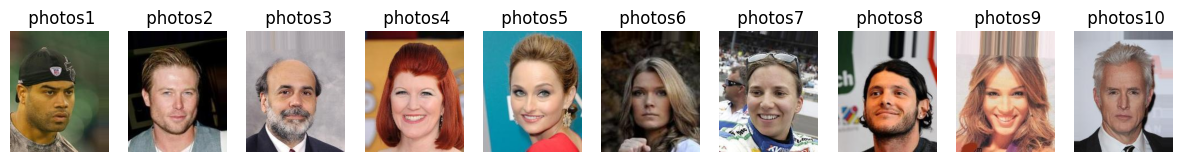

In [17]:

if len(image_paths) == 0:
    print("No images found")
else:

    num_to_show = min(10, len(image_paths))
    print(f"View {num_to_show} photos:")
    from PIL import Image



    plt.figure(figsize=(15, 5))
    for i in range(num_to_show):
        img = Image.open(image_paths[i])
        plt.subplot(1, num_to_show, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f" photos{i+1}")
    plt.show()


In [18]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class ColorToGrayDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        gray_image = transforms.functional.rgb_to_grayscale(image)
        return image, gray_image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = ColorToGrayDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [19]:
import torch.nn as nn

class ColorToGrayModel(nn.Module):
    def __init__(self):
        super(ColorToGrayModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [20]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorToGrayModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} — Loss: {running_loss/len(dataloader):.4f}")


Epoch 1/10 — Loss: 0.0325
Epoch 2/10 — Loss: 0.0047
Epoch 3/10 — Loss: 0.0030
Epoch 4/10 — Loss: 0.0022
Epoch 5/10 — Loss: 0.0019
Epoch 6/10 — Loss: 0.0018
Epoch 7/10 — Loss: 0.0016
Epoch 8/10 — Loss: 0.0015
Epoch 9/10 — Loss: 0.0014
Epoch 10/10 — Loss: 0.0013


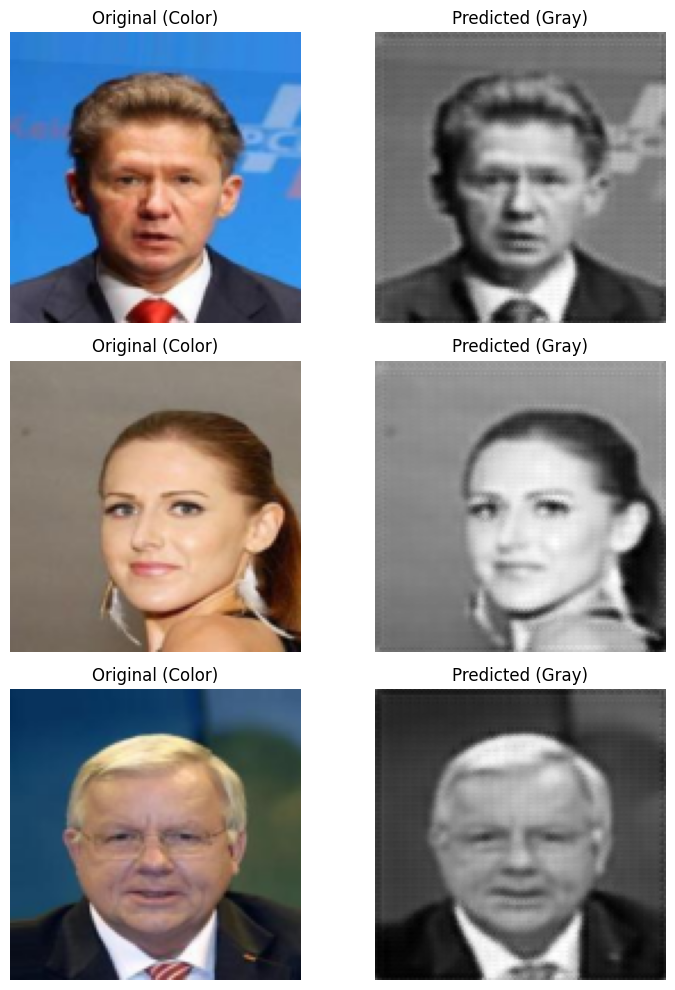

In [52]:

import numpy as np
import cv2
from PIL import Image

def pil_to_cv2(pil_img):

    if pil_img.mode != 'RGB':
        pil_img = pil_img.convert('RGB')
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

def cv2_to_pil(cv2_img):

    return Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))

def sharpen_image(pil_image):

    img_cv2 = pil_to_cv2(pil_image)
    blurred = cv2.GaussianBlur(img_cv2, (9, 9), 10.0)
    sharpened = cv2.addWeighted(img_cv2, 1.5, blurred, -0.5, 0)
    return cv2_to_pil(sharpened)
import random
import matplotlib.pyplot as plt


def enhance_details(image_np):

    enhanced = cv2.detailEnhance(image_np, sigma_s=10, sigma_r=0.15)
    return enhanced


model.eval()
sample_indices = random.sample(range(len(dataset)), 3)

fig, axs = plt.subplots(3, 2, figsize=(8, 10))
for i, idx in enumerate(sample_indices):
    color_img, gray_true = dataset[idx]
    input_tensor = color_img.unsqueeze(0).to(device)
    with torch.no_grad():
        gray_pred = model(input_tensor)

    axs[i, 0].imshow(color_img.permute(1, 2, 0).cpu().numpy())
    axs[i, 0].set_title("Original (Color)")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(gray_pred.squeeze().cpu().numpy(), cmap='gray')
    axs[i, 1].set_title("Predicted (Gray)")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()